In [1]:
import numpy as np
import scipy.signal.windows as wind
import matplotlib.pyplot as plt
from matplotlib import rcParams
import h5py
import scipy.signal.windows as wind

# From Jon's code
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]
    meta=dataFile['meta']
    gpsStart=meta['GPSstart'][()]
    utc=meta['UTCstart'][()]
    duration=meta['Duration'][()]
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 14

# Part A, Estimating the noise model

Uncomment to swap between different events. 

In [2]:
filenames0 = ['./ligo_data/H-H1_LOSC_4_V2-1126259446-32.hdf5',
       './ligo_data/L-L1_LOSC_4_V2-1126259446-32.hdf5',
       './ligo_data/GW150914_4_template.hdf5']

filenames1 = ['./ligo_data/H-H1_LOSC_4_V2-1135136334-32.hdf5',
      './ligo_data/L-L1_LOSC_4_V2-1135136334-32.hdf5',
      './ligo_data/GW151226_4_template.hdf5']

filenames2 = ['./ligo_data/H-H1_LOSC_4_V1-1167559920-32.hdf5',
      './ligo_data/L-L1_LOSC_4_V1-1167559920-32.hdf5',
      './ligo_data/GW170104_4_template.hdf5']

filenames3 = ['./ligo_data/H-H1_LOSC_4_V2-1128678884-32.hdf5',
      './ligo_data/L-L1_LOSC_4_V2-1128678884-32.hdf5',
      './ligo_data/LVT151012_4_template.hdf5']


files_all = [filenames0, filenames1, filenames2, filenames3]

In [3]:
# Load in data
strain_h, dt_h, utc_h = read_file(filenames0[0])
strain_l, dt_l, utc_l = read_file(filenames0[1])
template_h, template_l = read_template(filenames0[2])

if dt_h.size == dt_l.size: # check if time separation between each time sample is the same
    
    dt = dt_h
    sampling_rate = 1/dt

print('Duration of each sample: {0} s'.format(dt))
print('Sampling rate: {0} Hz'.format(sampling_rate)) 

print('\nHanford Data Information:')
print(strain_h.shape)
print(template_h.shape)

print('\nLivingstong Data Information:')
print(strain_l.shape)
print(template_l.shape)


if strain_l.size == strain_h.size: 
    n = strain_l.size
    print('\nNumber of points: {0}'.format(n))

# Get our frequencies
freqs = np.fft.fftfreq(n,d=dt)

Duration of each sample: 0.000244140625 s
Sampling rate: 4096.0 Hz

Hanford Data Information:
(131072,)
(131072,)

Livingstong Data Information:
(131072,)
(131072,)

Number of points: 131072


To estimate the noise matrix, we're going to need to get a smoothed version of our power spectrum, while also applying a window to avoid edge effects. The window I'm going to use (after browsing through the plethora of functions available here: https://en.wikipedia.org/wiki/Window_function) will be the Tukey window. I will also smooth the power spectrum using a Gaussian kernel as I did in the previous assignment. 

## A.1 The Tukey Window

The Tukey window is a relatively straightforward window. Since we expect the signal to be somewhere in the middle of the data, we want the window to be relatively flat in the middle, but that tappers out at the ends. I've plotted what it looks like below. 

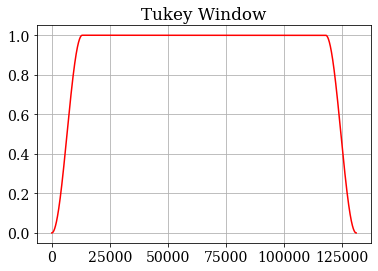

In [4]:
window = wind.tukey(n, alpha=0.2)
plt.plot(window, 'r')
plt.grid()
plt.title('Tukey Window')
plt.show()

## A.2 Smoothing out power spectrum

Pulling from last assignment, I'm just going to copy / paste my code from there and modify it to get a 1D power spectrum (instead of 2D). 

In [5]:
def get_gauss_kernel(map,sig,norm=False):
    nx=map.shape[0]
    x=np.fft.fftfreq(map.shape[0])*map.shape[0]
    kernel=np.exp((-0.5/sig**2)*x**2)
    if norm:
        kernel=kernel/kernel.sum()
    return kernel

In [6]:
def estimate_ps(vec, sig):    
    
    window = wind.tukey(len(vec), alpha = 0.2)
    windowed_vec = vec*window
    
    # Kernel is in Fourier space by default
    kernel = get_gauss_kernel(windowed_vec, sig, norm = True)
    
    kernel_ft = np.fft.fft(kernel)
    
    # Get power spec
    ps = np.abs(np.fft.fft(windowed_vec))**2
    
    ps_ft = np.fft.fft(ps)
    
    # Convolve
    smoothed_ps = np.fft.ifft(kernel_ft*ps_ft)
    
    return np.real(smoothed_ps)

In [7]:
# Get smoothed power spectrum for L and H
ps_l = estimate_ps(strain_l, sig=15)
ps_h = estimate_ps(strain_h, sig=15)

window = wind.tukey(n, alpha=0.2)

# Get raw ps for L and H for comparison
raw_ps_l = np.abs(np.fft.fft(strain_l*window))**2
raw_ps_h = np.abs(np.fft.fft(strain_h*window))**2

# Get windowed template ps 
template_ps_l = np.abs(np.fft.fft(template_l*window))**2
template_ps_h = np.abs(np.fft.fft(template_h*window))**2

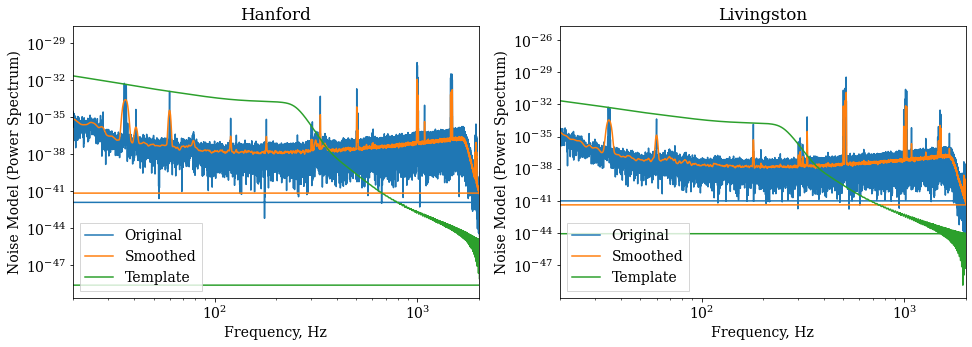

In [8]:
# Plot raw vs smoothed noise models
fig, axs = plt.subplots(1,2, figsize = (16,5))
axs[0].loglog(freqs, raw_ps_h, label = 'Original')
axs[0].loglog(freqs, ps_h,label = 'Smoothed')
axs[0].loglog(freqs, template_ps_h, label = 'Template')
axs[0].set_title('Hanford')
axs[0].set_xlim(20,2000)
leg0 = axs[0].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)

axs[1].loglog(freqs, raw_ps_l, label = 'Original')
axs[1].loglog(freqs, ps_l,label = 'Smoothed')
axs[1].loglog(freqs, template_ps_l, label = 'Template')
axs[1].set_title('Livingston')
axs[1].set_xlim(20,2000)
leg1 = axs[1].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)


for ax in axs.flat:
    ax.set(xlabel = 'Frequency, Hz', ylabel='Noise Model (Power Spectrum)')

The amount of smoothing is determined by the $\sigma$ parameter set in the `gauss_kernel`. Currently I have it set to 15, but this choice was somewhat arbitrary. I have chosen it such that the main prominent peaks are still visible (since they are physical), but that the rest is relatively smooth. I've also narrowed the frequencies which we care about from 20 Hz - 2000 Hz since this is where LIGO considers the data to be 'good'. 

In [9]:
# Noise models 
N_l = ps_l
N_h = ps_h

# Part B, Matched Filters

Before we carry out the matched filter, let's whiten the data and then take the cross correlation of the whitened template/strain. 

In [10]:
def whiten_data(strain, noise):
    
    window = wind.tukey(strain.size, alpha=0.2)
    
    noise_inv_sqrt = 1/np.sqrt(noise)
    
    strain_ft_w = np.fft.fft(strain*window)
    
    strain_ft_whitened = noise_inv_sqrt*strain_ft_w

    return np.real(np.fft.ifft(strain_ft_whitened))
                   
def matched_filter(strain, template):
    return np.real(np.fft.ifft(np.fft.fft(strain)*np.conj(np.fft.fft(template))))

In [11]:
strain_h_whitened = whiten_data(strain_h, N_h)
template_h_whitened = whiten_data(template_h, N_h)
mf_h = matched_filter(strain_h_whitened, template_h_whitened)


strain_l_whitened = whiten_data(strain_l, N_l)
template_l_whitened = whiten_data(template_l, N_l)
mf_l = matched_filter(strain_l_whitened, template_l_whitened)

time = np.arange(0, n)*dt

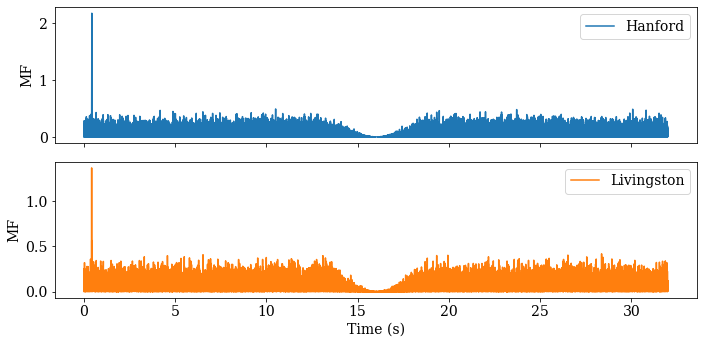

In [12]:
fig, ax = plt.subplots(2,1,sharex=True, figsize=(10,5))
ax[0].plot(time, abs(mf_h),label='Hanford')
ax[1].plot(time, abs(mf_l),label='Livingston', c="C1")
ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("MF")
ax[1].set_ylabel("MF")
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
# Write a routine that combines it all into one function

def get_matched_filter(filenames):
    # Load in data
    strain_h, dt_h, utc_h = read_file(filenames[0])
    strain_l, dt_l, utc_l = read_file(filenames[1])
    template_h, template_l = read_template(filenames[2])

    if dt_h.size == dt_l.size: # check if time separation between each time sample is the same
        dt = dt_h
        sampling_rate = 1/dt


    if strain_l.size == strain_h.size: 
        n = strain_l.size

    # Get our frequencies
    freqs = np.fft.fftfreq(n,d=dt)
    
    # Get smoothed power spectrum for L and H
    ps_l = estimate_ps(strain_l, sig=15)
    ps_h = estimate_ps(strain_h, sig=15)

    window = wind.tukey(n, alpha=0.2)

    # Get raw ps for L and H for comparison
    raw_ps_l = np.abs(np.fft.fft(strain_l*window))**2
    raw_ps_h = np.abs(np.fft.fft(strain_h*window))**2

    # Get windowed template ps 
    template_ps_l = np.abs(np.fft.fft(template_l*window))**2
    template_ps_h = np.abs(np.fft.fft(template_h*window))**2
    
    # Noise models 
    N_l = ps_l
    N_h = ps_h
    
    strain_h_whitened = whiten_data(strain_h, N_h)
    template_h_whitened = whiten_data(template_h, N_h)
    mf_h = matched_filter(strain_h_whitened, template_h_whitened)


    strain_l_whitened = whiten_data(strain_l, N_l)
    template_l_whitened = whiten_data(template_l, N_l)
    mf_l = matched_filter(strain_l_whitened, template_l_whitened)

    time = np.arange(0, n)*dt
    

    fig, ax = plt.subplots(2,1,sharex=True, figsize=(10,5))
    ax[0].plot(time, abs(mf_h),label='Hanford')
    ax[1].plot(time, abs(mf_l),label='Livingston', c="C1")
    ax[1].set_xlabel("Time (s)")
    ax[0].set_ylabel("MF")
    ax[1].set_ylabel("MF")
    ax[0].legend(fontsize=14)
    ax[1].legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return fig, mf_h, mf_l, template_h_whitened, template_l_whitened

Event 0
---------------------


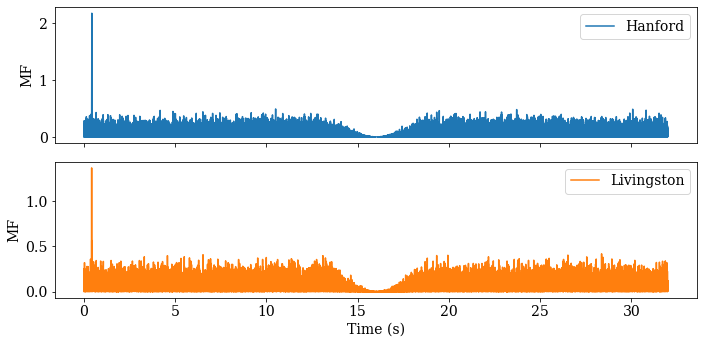

Event 1
---------------------


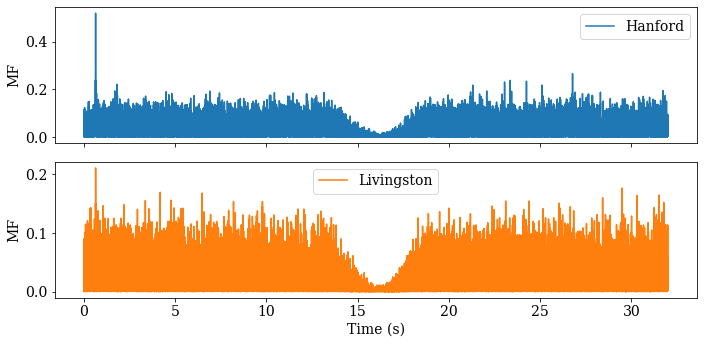

Event 2
---------------------


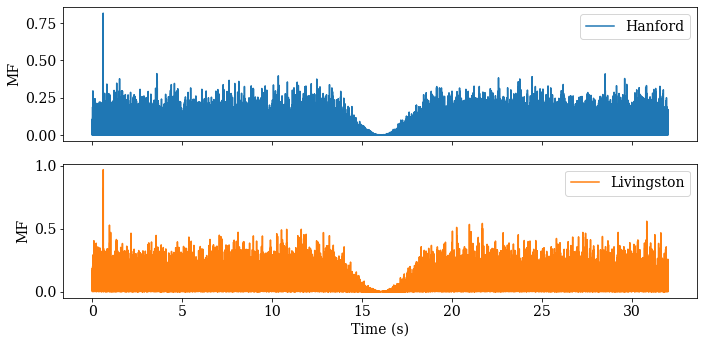

Event 3
---------------------


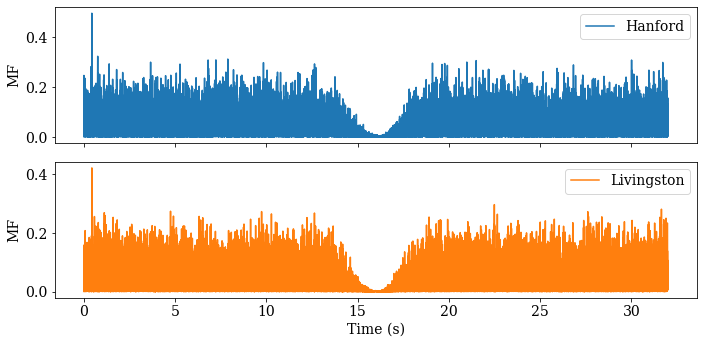

In [14]:
mf_h_list = []
mf_l_list = []
template_h_whitened_list = []
template_l_whitened_list = []
for i, f in enumerate(files_all): 
    print('Event {0}'.format(i))
    print('---------------------')
    fig, mf_h, mf_l, template_h_whitened, template_l_whitened = get_matched_filter(f)
    mf_h_list.append(mf_h)
    mf_l_list.append(mf_l)
    template_h_whitened_list.append(template_h_whitened)
    template_l_whitened_list.append(template_l_whitened)

# PART C, Estimating Noise and SNR

Recall, the Signal-to-Noise ratio is given by $$SNR = m/\sigma_m,$$
where
$$\sigma_m = \left< m m^T \right> = \sqrt{\left< \left(A^T N^{-1} A \right)^{-1}\right>}$$
and $m$ is our matched filter output. The above is obtained by simply expanding the expression and using our usual expression for $m$ and converting to a basis where we include the whitened noise.



In [15]:
def get_snr(template_h_whitened, template_l_whitened, mf_h, mf_l):
    
    sigma_h = np.sqrt(np.mean(template_h_whitened**2))
    sigma_l = np.sqrt(np.mean(template_l_whitened**2))
    SNR_h = abs(mf_h/sigma_h).max()
    SNR_l = abs(mf_l/sigma_l).max()
    
    
    return SNR_h, SNR_l

In [16]:
snr_h_list = []
snr_l_list = []
for i in range(len(files_all)):
    _template_h_whitened = template_h_whitened_list[i]
    _template_l_whitened = template_l_whitened_list[i]
    _mf_h = mf_h_list[i]
    _mf_l = mf_l_list[i]
    snr_h, snr_l = get_snr(_template_h_whitened, _template_l_whitened, _mf_h, _mf_l)
    snr_h_list.append(snr_h)
    snr_l_list.append(snr_l)

## C.1 Individual SNRs

In [17]:
for i in range(len(files_all)):
    print('Event {0}'.format(i))
    print('---------------------')
    print("Hanford matched filter SNR: %.2f" % (snr_h_list[i]))
    print("Livingston matched filter SNR: %.2f\n" % (snr_l_list[i]))

Event 0
---------------------
Hanford matched filter SNR: 18.49
Livingston matched filter SNR: 13.22

Event 1
---------------------
Hanford matched filter SNR: 9.97
Livingston matched filter SNR: 5.48

Event 2
---------------------
Hanford matched filter SNR: 8.48
Livingston matched filter SNR: 7.71

Event 3
---------------------
Hanford matched filter SNR: 6.49
Livingston matched filter SNR: 5.88



## C.2 Combined SNR

The combined SNR at both sites is simply $$\text{SNR}_\text{tot} = \sqrt{\text{SNR}_\text{h}^2 + \text{SNR}_\text{l}^2}$$

In [18]:
snr_tot = []
for i in range(len(files_all)):
    print('Event {0}'.format(i))
    print('---------------------')
    print("Total SNR: %.2f\n" % (np.sqrt(snr_l_list[i]**2 + snr_h_list[i]**2)))

Event 0
---------------------
Total SNR: 22.73

Event 1
---------------------
Total SNR: 11.38

Event 2
---------------------
Total SNR: 11.46

Event 3
---------------------
Total SNR: 8.76



# PART D, Estimating SNR using scatter

In [19]:
snr_scatter = []
for i in range(len(files_all)):
    
    sigma_h = np.std(mf_h_list[i][n//8:n//4]) # select a region that has pretty consistent scatter, excludes big peak
    sigma_l = np.std(mf_l_list[i][n//8:n//4]) 
    
    snr_h = abs(mf_h_list[i]).max() / sigma_h 
    snr_l = abs(mf_l_list[i]).max() / sigma_l
    
    combined_snr = np.sqrt(snr_h**2 + snr_l**2)
    
    print('Event {0}'.format(i))
    print('---------------------')
    print("Hanford scatter SNR: %.2f" % (snr_h))
    print("Livingston scatter SNR: %.2f" % (snr_l))
    print("Combined scatter SNR: %.2f\n"% combined_snr)
    

Event 0
---------------------
Hanford scatter SNR: 18.06
Livingston scatter SNR: 12.35
Combined scatter SNR: 21.87

Event 1
---------------------
Hanford scatter SNR: 9.76
Livingston scatter SNR: 5.16
Combined scatter SNR: 11.04

Event 2
---------------------
Hanford scatter SNR: 8.38
Livingston scatter SNR: 7.46
Combined scatter SNR: 11.22

Event 3
---------------------
Hanford scatter SNR: 6.17
Livingston scatter SNR: 5.68
Combined scatter SNR: 8.39



Overall, the SNRs tend to be pretty similar, though on average the scatter SNRs tend to be lower than the matched filter analytic SNRs. The difference might be due to how we determined the noise model $N$ which was somewhat arbitrarily chosen. 

# Part E

To get the frequency where the half of the power is to the left and half is to the right, we'll just look at the whitened template and find where the cumulative sum is half that of the total power. 

In [55]:
for i in range(4):
    # Power spectra of whitened templates
    template_h_ps = abs(np.fft.rfft(template_h_whitened_list[i]))**2
    template_l_ps = abs(np.fft.rfft(template_l_whitened_list[i]))**2

    # Get cumulative sum
    cumsum_h = np.cumsum(template_h_ps)
    cumsum_l = np.cumsum(template_l_ps)

    # Find the index closest to half the total sum
    ind_freq_h = np.argmin(abs(cumsum_h - template_h_ps.sum()/2))
    ind_freq_l = np.argmin(abs(cumsum_l - template_l_ps.sum()/2))
    
    print('Event {0}'.format(i))
    print('---------------------')    
    print('Hanford Half Power Frequency: %.2f Hz' % (freqs[ind_freq_h]))
    print('Livingston Half Power Frequency: %.2f Hz\n' % (freqs[ind_freq_l]))
    

Event 0
---------------------
Hanford Half Power Frequency: 107.53 Hz
Livingston Half Power Frequency: 118.75 Hz

Event 1
---------------------
Hanford Half Power Frequency: 83.19 Hz
Livingston Half Power Frequency: 109.19 Hz

Event 2
---------------------
Hanford Half Power Frequency: 100.09 Hz
Livingston Half Power Frequency: 76.50 Hz

Event 3
---------------------
Hanford Half Power Frequency: 84.31 Hz
Livingston Half Power Frequency: 98.56 Hz



# Part F

For the sake of this problem, I'm just going to use data from the first event (and not repeat for all 4 events). To start, let's get the difference in arrival time between Hanford and Livingston. To do this, we simply calculate the difference in timestamps at the peak SNR detection. 

In [62]:
time[np.argmax(mf_h)]

0.44140625

In [63]:
time[np.argmax(mf_l)]

0.443359375

In [66]:
delta_t = time[np.argmax(mf_h)] - time[np.argmax(mf_l)]
print('Difference in arrival time of GW:', np.abs(delta_t), 's')

Difference in arrival time of GW: 0.001953125 s


Now, if the difference in the arrival time of the gravitational wave is $t$, and the distance between the two detectors is $b$, then the geometric delay between the two sources is simply: 
\begin{equation}
ct = b\text{cos}\theta,
\end{equation}
where $\theta$ is the baseline angle and $c$ is the speed of light.
Using error propagation, the uncertainty in the position angle $\theta$ is going to be
$$\sigma_\theta= \left|\frac{\partial \theta}{\partial\Delta t}\sigma_{\Delta t}\right| = \frac{c\sigma_{\Delta t}}{b\sqrt{1-\left(\frac{c\Delta t}{b}\right)^2}} $$
The above equation requires that we have some uncertainty on our difference in the arrival time. For simplicity, let us just assume that we know the difference in arrival time up to $\pm 0.001$., e.g. $\sigma_{\Delta t} \sim 0.001$. Plugging in $b = 3000 $ km, $c = 3e8$ m/s, $\Delta t = 0.002$ s, we find that 

In [70]:
b = 3000 * 1000
c = 3e8
sigma_t = 0.001

delta_theta = c*sigma_t / (b* np.sqrt(1 - (c*delta_t/b)**2))
print('Uncertainty in position is approximately {0} degrees'.format(np.rad2deg(delta_theta)))

Uncertainty in position is approximately 5.842090418442503 degrees


# Problem 2

Suppose our beam is Gaussian with width $\sigma$, e.g. 
\begin{equation}
g(u) \sim \text{exp}\left[-\frac{u^2}{2\sigma^2}\right].
\end{equation}
The corresponding electric field pattern $f(x)$, where $x = ka\text{sin}\theta$ is the aperture, $a$ is radius and $k$ is the wavenumber is 
\begin{equation}
f(x) = \mathcal{F}[g(u)](x)
\end{equation}
where $\mathcal{F}$ is the Fourier transform of the beam pattern. Plugging in our expression for $g(u)$ yields an electric field pattern of
\begin{equation}
f(x) = \sqrt{2\pi\sigma^2}e^{-2\pi^2x^2\sigma^2}.
\end{equation}
Recalling that the power of the electric field is simply the field pattern squared, we find that
\begin{equation}
P(x) = [f(x)]^2 = 2\pi\sigma^2e^{-4\pi^2x^2\sigma^2}.
\end{equation}
Maximizing with respect to $\sigma$ (e.g. taking the derivative of the power w.r.t $\sigma$ and setting the expression equal to zero) yields a power that is maximized for 
\begin{equation}
\boxed{\sigma_\text{max} = \frac{1}{2\pi x} = \frac{\lambda}{4\pi^2 a\text{sin}\theta}}.
\end{equation}

## Plotting w.r.t $\sigma$

For simplicity, let's assume our radius is 1. The power at the antenna is given by the equation above. Let's assume that $\lambda = 50$cm, $\theta = 1$. The power as a function of $\sigma$ would look something like: 

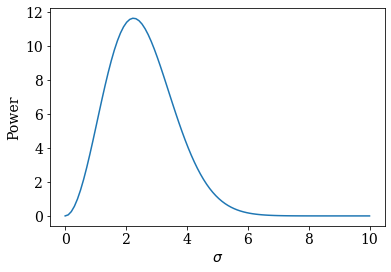

In [34]:
sigma = np.linspace(0, 10, 100)
lamda = 50
a = 1
x = (2*np.pi / lamda) * a * 1
power = 2*np.pi*sigma**2*np.exp(-4*np.pi*x**2*sigma**2)

plt.plot(sigma, power)
plt.xlabel('$\sigma$')
plt.ylabel('Power')
plt.show()

Recall that the effective area is Area $\times$ Average Illumation Relative to peak. The average illumation relative to the peak is given by the power at $\sigma_\text{max}$, so the effective area is
\begin{equation}
A_\text{eff} \sim 4\pi r^2 \times \frac{\lambda^2}{8\pi^3a^2sin^2\theta},
\end{equation}
where the second term comes from substituting in $\sigma_\text{max}$ into the power. 
At the peak, then, the ratio of $A_\text{eff}/A$ is simply 
\begin{equation}
A_\text{eff}/A \sim \frac{\lambda^2}{8\pi^3a^2sin^2\theta}.
\end{equation}


To be entirely honest, I have no idea what I'm doing but tried to put something together that made a least a tiny bit of sense.